# CICIOT 2023 Baseline Code

In [10]:
import pandas as pd 
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from data.CICIoT2023.ciciot2023_cleaning import *

In [2]:
full_df = load_and_clean(base_path="./../data/CICIoT2023/")

Listing CSV files in: ./../data/CICIoT2023/
Total files: 6
Reading: ./../data/CICIoT2023/BenignTraffic.pcap.csv
Reading: ./../data/CICIoT2023/BenignTraffic1.pcap.csv
Reading: ./../data/CICIoT2023/BenignTraffic2.pcap.csv
Reading: ./../data/CICIoT2023/BenignTraffic3.pcap.csv
Reading: ./../data/CICIoT2023/DoS-HTTP_Flood.pcap.csv
Reading: ./../data/CICIoT2023/DoS-HTTP_Flood1.pcap.csv
Full Shape: (1170052, 40)
Before cleaning: (1170052, 40)
Removed 4623 duplicates
Dropped 4691 missing values
After cleaning: (1165361, 40)
Label
BENIGN      1093876
dos_http      71485
Name: count, dtype: int64


In [5]:
full_df.head()

,Header_Length,Protocol Type,Time_To_Live,Rate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,ack_flag_number,ece_flag_number,...,Tot sum,Min,Max,AVG,Std,Tot size,IAT,Number,Variance,Label
0,32.0,6,198.4,430.273287,0.0,0.0,0.0,0.0,1.0,0.0,...,5004,66,2962,500.4,977.325512,500.4,0.002324,10,9.551652e+05,BENIGN
1,22.4,6,114.4,484.616113,0.0,0.0,0.0,0.2,0.6,0.0,...,1404,60,583,140.4,174.827026,140.4,0.002179,10,3.056449e+04,BENIGN
2,27.2,6,62.5,398.610950,0.0,0.0,0.0,0.0,0.8,0.0,...,10784,60,1514,1078.4,701.384536,1078.4,0.003173,10,4.919403e+05,BENIGN
3,23.2,6,62.1,425.187438,0.0,0.1,0.0,0.0,0.6,0.0,...,7884,60,2962,788.4,1025.156812,788.4,0.002507,10,1.050946e+06,BENIGN
4,32.0,6,64.0,1563.521956,0.0,0.0,0.0,0.1,1.0,0.0,...,13782,156,1514,1378.2,429.437306,1378.2,0.000660,10,1.844164e+05,BENIGN


In [4]:
# Filter dataset
attack_labels = ['dos_http']
all_labels = ['BENIGN'] + attack_labels

filtered_df = full_df[full_df['Label'].isin(all_labels)].copy()

print("Class distribution after filtering:")
print(filtered_df['Label'].value_counts())

In [5]:
X_full = filtered_df.drop('Label', axis=1)
y_full = filtered_df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full,
    stratify=y_full,
    test_size=0.1,
    random_state=42
)

print("Train label distribution (before balancing):")
print(y_train.value_counts())

Train label distribution (before balancing):
Label
BENIGN      984488
dos_http     64336
Name: count, dtype: int64


In [6]:
# Balance ONLY the training set (downsample the majority class to match the minority)
train_df = X_train.copy()
train_df['Label'] = y_train.values

counts = train_df['Label'].value_counts()
attack_min_counts = counts.min()

attack_df = train_df[train_df['Label'].isin(attack_labels)]
benign_sampled_df = train_df[train_df['Label'] == 'BENIGN'].sample(n=attack_min_counts, random_state=42)

balanced_train_df = pd.concat([attack_df, benign_sampled_df], ignore_index=True).sample(frac=1, random_state=42)

In [7]:
X_train_balanced = balanced_train_df.drop('Label', axis=1)
y_train_balanced = balanced_train_df['Label']

print("X_train_balanced shape:", X_train_balanced.shape)
print("y_train_balanced distribution:")
print(y_train_balanced.value_counts())

X_train_balanced shape: (128672, 39)
y_train_balanced distribution:
Label
BENIGN      64336
dos_http    64336
Name: count, dtype: int64


In [8]:
os.makedirs('models', exist_ok=True)

total_trees = 100
step = 10

clf = RandomForestClassifier(n_estimators=step, warm_start=True, n_jobs=-1, random_state=42)
start = time.time()
for n in range(step, total_trees + 1, step):
    clf.set_params(n_estimators=n)
    clf.fit(X_train_balanced, y_train_balanced)
    elapsed = time.time() - start
    print(f"Trained {n}/{total_trees} trees ({n/total_trees*100:.1f}%), elapsed {elapsed:.1f}s")

Trained 10/100 trees (10.0%), elapsed 0.6s
Trained 20/100 trees (20.0%), elapsed 1.1s
Trained 30/100 trees (30.0%), elapsed 1.6s
Trained 40/100 trees (40.0%), elapsed 2.0s
Trained 50/100 trees (50.0%), elapsed 2.5s
Trained 60/100 trees (60.0%), elapsed 3.0s
Trained 70/100 trees (70.0%), elapsed 3.5s
Trained 80/100 trees (80.0%), elapsed 4.0s
Trained 90/100 trees (90.0%), elapsed 4.4s
Trained 100/100 trees (100.0%), elapsed 4.8s


In [11]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Generic evaluation function for binary or multiclass classification.

    Parameters:
    -----------
    y_true : array-like
    y_pred : array-like
    model_name : str (for plot title)
    """
    if hasattr(y_true, "cpu"):
        y_true = y_true.cpu().numpy()
    if hasattr(y_pred, "cpu"):
        y_pred = y_pred.cpu().numpy()

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    y_true_str = y_true.astype(str)
    y_pred_str = y_pred.astype(str)

    all_labels = np.unique(np.concatenate([y_true_str, y_pred_str]))

    print(f"\n=== {model_name} Classification Report ===\n")
    print(classification_report(y_true_str, y_pred_str, labels=all_labels, digits=4))

    cm = confusion_matrix(y_true_str, y_pred_str, labels=all_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=all_labels, yticklabels=all_labels)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Confusion Matrix (counts)")
    plt.tight_layout()
    os.makedirs('models', exist_ok=True)
    plt.show()


=== Random Forest CICIoT2023 (Balanced Training Set) Classification Report ===

              precision    recall  f1-score   support

      BENIGN     1.0000    1.0000    1.0000    109388
    dos_http     1.0000    0.9999    0.9999      7149

    accuracy                         1.0000    116537
   macro avg     1.0000    0.9999    1.0000    116537
weighted avg     1.0000    1.0000    1.0000    116537



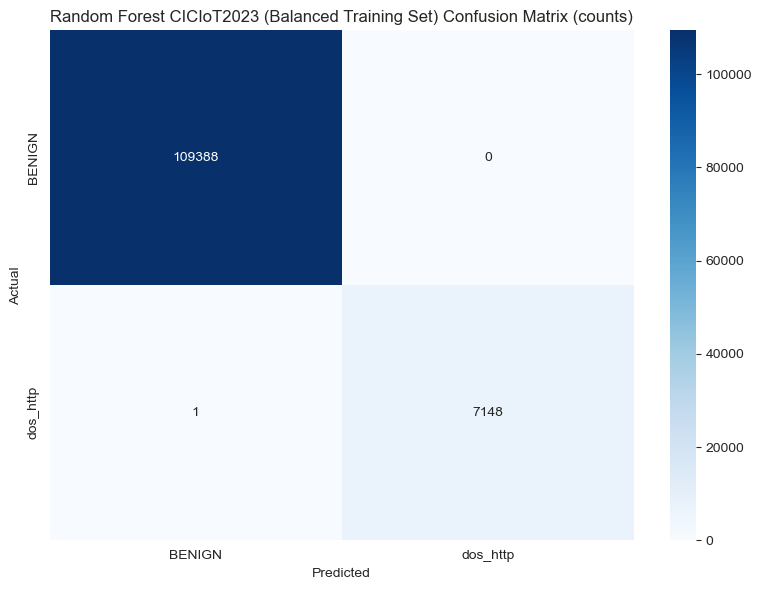

In [12]:
evaluate_model(
    y_true=y_test,
    y_pred=clf.predict(X_test),
    model_name="Random Forest CICIoT2023 (Balanced Training Set)"
)

In [13]:
# Save model + encoders
os.makedirs('models', exist_ok=True)
out_path = 'models/random_forest_cic2023.joblib'
joblib.dump({
    'model': clf
}, out_path)
print("Saved model to", out_path)

Saved model to models/random_forest_cic2023.joblib


# CNN-LSTM Baseline

Device: cuda
Classes: ['BENIGN', 'dos_http']
Train label counts: [64336 64336]
Test label counts: [109388   7149]
X_train_scaled: (128672, 39) X_test_scaled: (116537, 39)
n_features: 39
CNNLSTM(
  (conv): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ReLU()
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 64, batch_first=True)
  (head): Sequential(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=64, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features

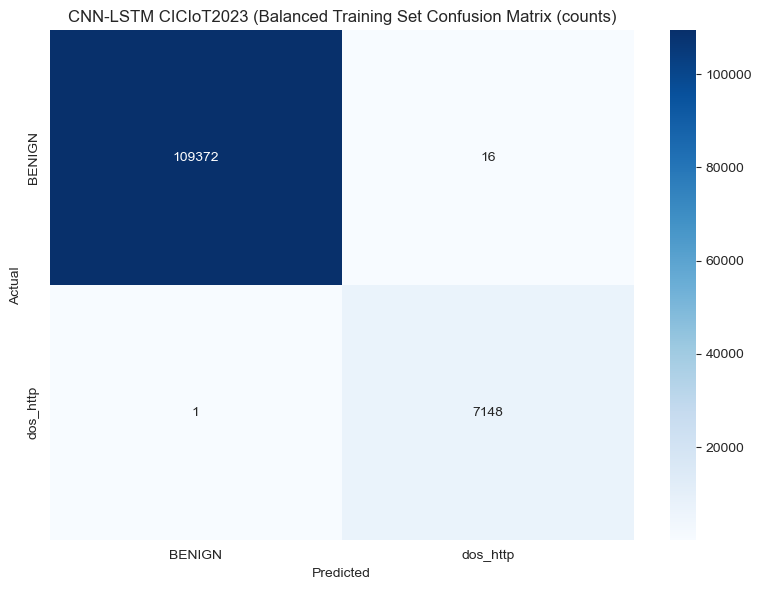

In [15]:

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelEncoder, StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
# STEP 2: Encode labels + scale features (fit scaler on train only)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_balanced.astype(str))
y_test_enc = le.transform(y_test.astype(str))

print("Classes:", list(le.classes_))
print("Train label counts:", np.bincount(y_train_enc))
print("Test label counts:", np.bincount(y_test_enc))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled:", X_train_scaled.shape, "X_test_scaled:", X_test_scaled.shape)


class NetworkDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # Return (C, L) for Conv1d: channels=1, length=n_features
        x = self.X[idx].unsqueeze(0)  # (1, F)
        y = self.y[idx]
        return x, y


train_ds = NetworkDataset(X_train_scaled, y_train_enc)
test_ds = NetworkDataset(X_test_scaled, y_test_enc)

train_loader = DataLoader(train_ds, batch_size=4096, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=4096, shuffle=False, num_workers=0, pin_memory=True)

n_features = X_train_scaled.shape[1]
print("n_features:", n_features)


# Define CNN-LSTM model

class CNNLSTM(nn.Module):
    def __init__(self, n_features: int):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),
        )

        # After two pool(2): length becomes roughly n_features / 4
        self.lstm = nn.LSTM(
            input_size=128,  # channels become features per timestep after permute
            hidden_size=64,
            num_layers=1,
            batch_first=True
        )

        self.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)  # logits (use BCEWithLogitsLoss)
        )

    def forward(self, x):
        # x: (N, 1, F)
        x = self.conv(x)  # (N, 128, L)
        x = x.permute(0, 2, 1)  # (N, L, 128) -> for LSTM
        out, (h, c) = self.lstm(x)
        last = out[:, -1, :]  # (N, 64)
        logits = self.head(last).squeeze(1)  # (N,)
        return logits


model = CNNLSTM(n_features).to(device)
print(model)
from torch.utils.data import random_split

torch.manual_seed(42)

val_frac = 0.1
n_total = len(train_ds)
n_val = int(n_total * val_frac)
n_train = n_total - n_val

train_ds_split, val_ds = random_split(train_ds, [n_train, n_val])

train_loader = DataLoader(train_ds_split, batch_size=4096, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=4096, shuffle=False, num_workers=0, pin_memory=True)

print("Train/Val sizes:", len(train_ds_split), len(val_ds))
# Train
import copy
import time

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def train_one_epoch(model_to_train, loader):
    model_to_train.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True).float()

        optimizer.zero_grad(set_to_none=True)
        logits = model_to_train(xb)
        yb = yb.view_as(logits)

        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)


@torch.no_grad()
def eval_loss_and_acc(model_to_eval, loader):
    model_to_eval.eval()
    total_loss = 0.0
    correct = 0
    n = 0

    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True).float()

        logits = model_to_eval(xb)
        yb = yb.view_as(logits)

        loss = criterion(logits, yb)
        total_loss += loss.item() * xb.size(0)

        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()
        correct += (preds == yb).sum().item()
        n += yb.numel()

    return total_loss / len(loader.dataset), correct / n


# Early stopping settings
patience = 5
min_delta = 1e-4  # required improvement
best_val_loss = float("inf")
best_state = copy.deepcopy(model.state_dict())
patience_left = patience

epochs = 10
start = time.time()

for epoch in range(1, epochs + 1):
    train_loss = train_one_epoch(model, train_loader)
    val_loss, val_acc = eval_loss_and_acc(model, val_loader)

    elapsed = time.time() - start
    print(
        f"Epoch {epoch:02d}/{epochs} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.4f} | elapsed={elapsed:.1f}s")

    # Check improvement
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_state = copy.deepcopy(model.state_dict())
        patience_left = patience
    else:
        patience_left -= 1
        if patience_left <= 0:
            print(f"Early stopping triggered. Best val_loss={best_val_loss:.4f}")
            break

# Restore best model
model.load_state_dict(best_state)
print("Restored best model weights (by val_loss).")


# Classification report + confusion matrix
@torch.no_grad()
def predict_probs(model_to_eval, loader):
    model_to_eval.eval()
    probs_list, y_list = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        logits = model_to_eval(xb)
        probs = torch.sigmoid(logits).cpu().numpy()
        probs_list.append(probs)
        y_list.append(yb.numpy())
    return np.concatenate(probs_list), np.concatenate(y_list)


probs, yy = predict_probs(model, test_loader)
preds = (probs >= 0.5).astype(int)

yy_labels = le.inverse_transform(yy.astype(int))
pred_labels = le.inverse_transform(preds.astype(int))

evaluate_model(
    y_true=yy_labels,
    y_pred=pred_labels,
    model_name="CNN-LSTM CICIoT2023 (Balanced Training Set"
)